# Case 3
Otso Pohjola<br>
Last edited: 11.03.2018<br>
Cognitive Systems for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## 1. Objectives
Is it possible to classify medical texts by their content? I'm answering that question in this project by training a recurrent neural network specialized in natural language processing.

## 2. Required libraries
I mainly used NLTK and Keras.

In [383]:
import os
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

In [384]:
#Functions

#loadFiles() loads the text and label files from given labelName location.
#Didn't change the logic here, just made the naming more clear for me.
def loadFiles(labelNames,texts,labels):
    for labelName in labelNames:
        labelDir = os.path.join(trainDir, labelName)
        for fileName in os.listdir(labelDir):
            file = open(os.path.join(labelDir, fileName))
            texts.append(file.read())
            file.close()
            labels.append(labelNames.index(labelName))

#filterAndStem filters given tokenizer attribute.
#It removes the stop words, small words and digits.
def filterAndStem(attribute):
    
    #Filter the attribute
    filteredWords = [word for word in attribute if word not in stops]
    filteredWords = [word for word in filteredWords if len(word)>5]
    filteredWords = [word for word in filteredWords if not word.isdigit()]

    filteredMap = {}
    stemMap = {}

    #Create a new map with filtered keys but original values.
    for word in filteredWords:
        filteredMap[word] = attribute[word]

    #Create a new map with stemmed keys but original values.
    ps = PorterStemmer()
    for word in filteredMap.keys():
        stemMap[ps.stem(word)] = filteredMap[word]

    return(stemMap)

## 3. Data description and preprocessing
The data was inherently split to ~10 000 train and test medical texts of 23 categories. I dont like the 50:50 split, but transfering test data to train turned out to be more tedious than I expected so it was left this way. The texts are pretty short overall and unevenly distributed between the categories.

Preprocessing was pretty standard text analysis stuff: 
* Text was tokenized
* It was turned to lower case
* Removed stop words
* Filtered short words and numbers
* Stemmed every word

This way I get rid of most of the white noise that's usually mixed in the natural language. I'm only interested the medical terms and words that separate the categories. <br/> Detailed category descriptions in http://disi.unitn.it/moschitti/corpora/First-Level-Categories-of-Cardiovascular-Disease.txt

In [385]:
#Download the stop word list if first time running.
#nltk.download("stopwords")
stops = set(stopwords.words("english"))

#Tota length of used text and the amount of observed words.
textLength = 100
wordLimit = 5000

mainDir = 'ohsumed-first-20000-docs'
trainDir = os.path.join(mainDir, 'training')
testDir = os.path.join(mainDir, 'test')

#Initialize train and test arrays.
trainLabelNames = [output for output in os.listdir(trainDir)]
trainTexts = []
trainLabels = []

testLabelNames = [output for output in os.listdir(testDir)]
testLabels = []
testTexts = []

#Load the files
loadFiles(trainLabelNames,trainTexts,trainLabels)
loadFiles(testLabelNames,testTexts,testLabels)

In [386]:
#Wanted to transfer some data from test to train but encountered too many difficulties.

#indices = np.arange(len(testTexts))
#np.random.shuffle(indices)

#testTexts = np.asarray(testTexts)
#testLabels = np.asarray(testLabels)
#testLabels = to_categorical(testLabels)

#testTexts = testTexts[indices]
#testLabels = testLabels[indices]

#trainTexts = trainTexts.append(testTexts[:2086])
#trainLabels = trainLabels.append(testLabels[:2086])
#print(len(trainTexts))


In [387]:
#Added ' to filters
tokenizer = Tokenizer(num_words = wordLimit,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',)
tokenizer.fit_on_texts(trainTexts)
print('Found %s unique tokens' % len(tokenizer.word_index))

Found 30517 unique tokens


In [389]:
#Get new maps for tokenizer attributes
word_counts = filterAndStem(tokenizer.word_counts)
word_docs = filterAndStem(tokenizer.word_docs)
word_index = filterAndStem(tokenizer.word_index)
document_count = tokenizer.document_count

#wordLimit = len(word_index.keys())
#new amount of tokens
print('Found %s unique tokens after filtering' % len(word_index))

Found 16029 unique tokens after filtering


As seen in the next cell, all words are now long and stems. Also many on them are relevant medical terms.

In [398]:
print(word_counts)

{'augment': 1, 'mentoplasti': 4, 'mersilen': 10, 'differ': 7, 'materi': 2, 'avail': 63, 'howev': 1401, 'optim': 1, 'implant': 4, 'sever': 15, 'number': 2, 'experienc': 16, 'surgeon': 133, 'turn': 3, 'absorb': 3, 'dacron': 32, 'polyest': 10, 'conform': 1, 'easili': 100, 'layer': 5, 'achiev': 16, 'tailor': 4, 'dimens': 19, 'mccollough': 2, 'plastic': 6, 'surgeri': 11, 'clinic': 28, 'birmingham': 4, 'patient': 3454, 'period': 8, 'underw': 936, 'provid': 1, 'excel': 251, 'tensil': 5, 'strength': 5, 'durabl': 8, 'surgic': 129, 'adapt': 1, 'overal': 591, 'complic': 1, 'infect': 13, 'remov': 4, 'secondari': 1, 'experi': 46, 'remain': 135, 'choic': 14, 'multipl': 2, 'intracrani': 208, 'mucocel': 9, 'associ': 4, 'phaeohyphomycosi': 11, 'paranas': 25, 'sinus': 41, 'purpos': 3, 'articl': 17, 'clinician': 63, 'pathogen': 10, 'fungu': 10, 'call': 84, 'exserohilum': 8, 'rostratum': 8, 'speci': 165, 'etiolog': 6, 'agent': 507, 'constel': 16, 'entiti': 125, 'caus': 143, 'dematiac': 4, 'fungal': 113, '

In [390]:
#Replace the original tokenizer's attributes with filtered ones.
tokenizer = Tokenizer(num_words = wordLimit)
tokenizer.word_counts = word_counts
tokenizer.word_docs = word_docs
tokenizer.word_index = word_index
tokenizer.document_count = document_count

#The sequence's values go over wordLimit since the fitting part was done before removing extra words.
#Hopefully this doesn't affect anything since the order is the same.
sequences = tokenizer.texts_to_sequences(trainTexts)

data = pad_sequences(sequences, maxlen = textLength)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (10433, 100)


In [391]:
#Shuffle the training data 
np.random.seed(1)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]

trainLabels = np.asarray(trainLabels)
trainLabels = to_categorical(trainLabels)
trainLabels = trainLabels[indices]

## 4. Modeling and compilation
In the model I used one Embedding, two LSTM and one dense layer. Using convolutional network for this task didn't interest me as much as RNN, so that's why I only played around with this concept.

The Embedding layer is giving an enormous vector of 160 variables, and since it makes the results better I'd say the words have extremely deep relationships. The dropout was put to the first LSTM layer as an attempt to fight overfitting, tried the value 0.2 first but it was too much. The dense layer's activation function was softmax. As a loss function I used categorical crossentropy.


In [392]:

model = Sequential()
#Increasing the Embedding layer's output dimension and adding another LSTM layer made the results more accurate.
#Also Increasing the maximum amount of words helped up to certain point (tried values between 100 and 7000).
#In case some of the texts were longer, I tried various text lengths between 100 and 400 but the higher values only
#led in negative results.
model.add(Embedding(wordLimit, 160, input_shape=(textLength,)))
model.add(LSTM(50,dropout=0.1,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(23, activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 100, 160)          800000    
_________________________________________________________________
lstm_37 (LSTM)               (None, 100, 50)           42200     
_________________________________________________________________
lstm_38 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_29 (Dense)             (None, 23)                1173      
Total params: 863,573
Trainable params: 863,573
Non-trainable params: 0
_________________________________________________________________


## 5. Training and Validation
* Batch size: 64
* Validation split: 0.1 (1044 samples)
* Epochs: 15

In [393]:
#Fit the model to training data

history = model.fit(data, trainLabels, epochs = 15, batch_size = 64,
                   validation_split=0.1)

Train on 9389 samples, validate on 1044 samples
Epoch 1/15
9389/9389 [==============================] - 333s 35ms/step - loss: 2.7904 - acc: 0.1872 - val_loss: 2.6189 - val_acc: 0.2529
Epoch 2/15
9389/9389 [==============================] - 235s 25ms/step - loss: 2.6137 - acc: 0.2439 - val_loss: 2.4913 - val_acc: 0.2854
Epoch 3/15
9389/9389 [==============================] - 179s 19ms/step - loss: 2.4978 - acc: 0.2663 - val_loss: 2.4142 - val_acc: 0.3017
Epoch 4/15
9389/9389 [==============================] - 184s 20ms/step - loss: 2.4306 - acc: 0.2752 - val_loss: 2.3963 - val_acc: 0.2893
Epoch 5/15
9389/9389 [==============================] - 180s 19ms/step - loss: 2.3733 - acc: 0.2870 - val_loss: 2.3532 - val_acc: 0.3084
Epoch 6/15
9389/9389 [==============================] - 195s 21ms/step - loss: 2.3221 - acc: 0.3002 - val_loss: 2.3548 - val_acc: 0.3103
Epoch 7/15
9389/9389 [==============================] - 182s 19ms/step - loss: 2.2756 - acc: 0.3137 - val_loss: 2.3090 - val_acc: 

## 6. Evaluation
Highest validation accuracy was around 32%, which is alright, but I think the 10% split validation starts to overfit really quickly. The overfitting starts after the epoch 8 or 10.

The test accuracy is even better compared validation, 37%. I tried to figure out the reason for this but I'm not sure. For some reason the 10 000 test text dataset matches the model better than the 1 000 validation text dataset.

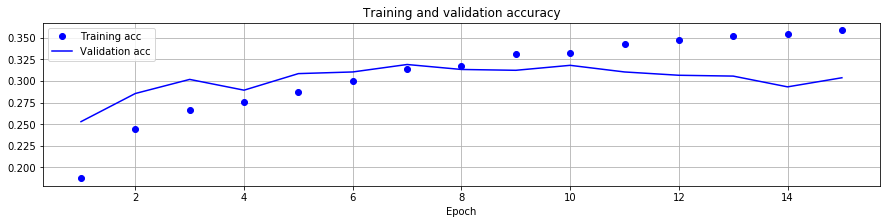

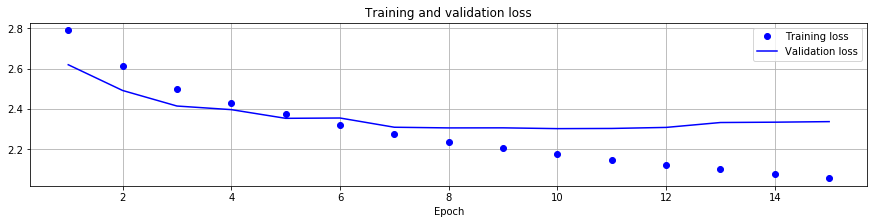

In [394]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 3))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.legend()


plt.figure(figsize=(15, 3))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid()
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [397]:
testSequences = tokenizer.texts_to_sequences(testTexts)
xTest = pad_sequences(testSequences, maxlen=textLength)
test_labels = np.asarray(testLabels)
yTest = to_categorical(testLabels)
model.evaluate(xTest, yTest)

10433/10433 [==============================] - 62s 6ms/step


[2.0110454455919284, 0.37333461132943546]

## 7. Results and Discussion
The ~40% accuracy means each category has some unique characteristics that can be found in the texts. However, most of the time the words are mixed between each other which suggests that the network can't tell them apart. And there's two reasons for this; either I did something terribly wrong in the preprocessing, or most of the words are just too similar. Maybe the texts only differ ~40% overall and the rest is common words? 

The text matrix below shows how the texts are all scattered unevenly, and it could be because of the long embedding vector, too similar words are mixed between categories. I'm surprised by how scattered the results are, and as a follow up I'd get rid of the texts that the model recognizes the worst and see if it helps.

In hope of finding more medical terms that fit to exactly one category, I already tried filtering even longer words, up to six character. Unfortunately the results were poor. 

In [403]:
# http://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
cm = confusion_matrix(testLabels, y_pred)
print(np.array2string(cm, max_line_width = 100))

[[ 10   3   0  67   9  22   1  31   3  21   6  25  10  52   4   2   5  21   1  24  20   4  82]
 [  2   1   0  20   1  10   0   8   1   9   3   7   7  27   0   1   3   5   0  12   5   0  36]
 [  0   0   1  15   0   7   0   1   0   5   0   3   1  10   2   0   1   4   1   3   2   0   9]
 [ 42   2   2 163  25  74   3  65   3  57  17  59  26 197   7   8  18  34   3  78  57   1 222]
 [  8   1   1  41   7  14   2  13   1  16   9  14   7  48   2   4   5   7   0  22  13   0  48]
 [ 13   3   0  85  15  46   1  22   3  25   9  29  11 112   5   3   7  26   2  34  30   0 107]
 [  2   0   0  15   2   7   0   7   0   3   1   5   0  16   1   0   2   7   1   6   3   0  22]
 [ 10   0   2  53  14  37   2  15   2  22   7  26  17  81   1   4  16  12   0  32  14   1 105]
 [  3   0   0  16   2   6   2   6   0  10   1   7   3  22   1   1   1   2   0   5   9   0  28]
 [  7   3   1  99  16  47   4  27   3  34  19  23  10 111   7   5  13  32   2  32  26   1  99]
 [  5   1   0  24   4  17   0  14   2   7   2   8 

## 8. Conclusions
I don't think this project was a failure when it comes to categorizing medical texts, but neither was it a breakthrough. It proves that medical texts can be categorized using an AI, my model just doesn't do it  perfectly.